另外，使用 Jupyter Notebook 进行长期模型训练时，可能由于 GPU 内存无法及时释放导致该报错

In [17]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))
    

    
'''

dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            reset_keras()
            # training your model here
            
'''

'\n\ndense_layers = [0, 1, 2]\nlayer_sizes = [32, 64, 128]\nconv_layers = [1, 2, 3]\n\nfor dense_layer in dense_layers:\n    for layer_size in layer_sizes:\n        for conv_layer in conv_layers:\n            reset_keras()\n            # training your model here\n            \n'

the classification problem is to predict a single discrete label of an input data point, another common type of machine-learning problem is regression, which consists of predicting a continuous value instead of a discrete label: for instance, predicting the temperature tomorrow, given meteorological data; or predicting the time that a software project will take to complete, given its specifications

note: confusingly, logistic regression isn't a regression algorithm -- it's a classification algorithm

##### The Boston Housing Price Dataset

attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate and so on

relatively fewer data points -- 506
- split between 404 training samples and 102 test samples

each feature in the input data has a different scale:
- some values are proportions, which take values between 0 and 1
- others are categorical, take values between 1 and 12
- others between 0 and 100, and so on

In [1]:
# loading the Boston housing dataset
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

2024-04-02 14:42:03.179606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 14:42:03.485712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-02 14:42:04.221495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


57026/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [3]:
test_data.shape

(102, 13)

each input consists with 13 numerical features, such as  percapita crime rate, average number of rooms per dwelling, accessibility to highways and so on

the targets are the median values of owner-occupied homes: (per thousand adjusted)

In [4]:
test_targets

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2, 18.6,
       14.5, 17.8, 50. , 20.8, 24.3, 24.2, 19.8, 19.1, 22.7, 12. , 10.2,
       20. , 18.5, 20.9, 23. , 27.5, 30.1,  9.5, 22. , 21.2, 14.1, 33.1,
       23.4, 20.1,  7.4, 15.4, 23.8, 20.1, 24.5, 33. , 28.4, 14.1, 46.7,
       32.5, 29.6, 28.4, 19.8, 20.2, 25. , 35.4, 20.3,  9.7, 14.5, 34.9,
       26.6,  7.2, 50. , 32.4, 21.6, 29.8, 13.1, 27.5, 21.2, 23.1, 21.9,
       13. , 23.2,  8.1,  5.6, 21.7, 29.6, 19.6,  7. , 26.4, 18.9, 20.9,
       28.1, 35.4, 10.2, 24.3, 43.1, 17.6, 15.4, 16.2, 27.1, 21.4, 21.5,
       22.4, 25. , 16.6, 18.6, 22. , 42.8, 35.1, 21.5, 36. , 21.9, 24.1,
       50. , 26.7, 25. ])

##### Preparing the Data

it would be problematic to feed into a neural network values that all take wildly different rages, the network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult

feature-wise normalization:
- for each feature in the input data (a column in the input data matrix), subtract teh mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation
- this can easily done in numpy:

In [5]:
# normalizing the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

note that the quantities used for normalizing the test data are computed using the training data, never use any quantity computed on the test data in the work flow

##### Building the Network

in general, the less training data, the worse overfitting will be, and using a small network is one way to mitigate overfitting, so we use only two hidden layers here, each with 64 units

In [8]:
# model definition
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

- the network ends with a single unit and no activation (it will be a linear layer), this is a typical setup for scalar regression (a regression where you're trying to predict a single continuous value)
- applying an activation function would constraint the range of the output

the network is compiled with the 'mse' loss function -- mean square error
- the square of the difference between the predictions and the targets
- mse is a widely used loss function for regression problem

metric monitoring during training with 'mae' -- mean absolut error
- the absolute value of the difference between the predictions and the targets

##### Validating the Approach Using K-Fold Validation

split the data into a training set and a validation to evaluate the network while keeping adjusting its parameters, but because so few data points, the validation set would being very small, and as a consequence, the validation scores might change alot depending on the sets chosen:
- the validation scores might have a high variance with regard to the validation split

k-fold cross-validation:
- splitting the available data into k partitions (typically 4 or 5)
- instantiating k identical models
- training each one on k-1 partitions while evaluating on the remaining
- the validation score for the model used is then the average of the k validation scores obtained

![3-Fold Cross-Validation](./3_fold_cross_val.png)

In [12]:
# k-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i) # prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( # prepares the training data: data from all other partitions
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)
    
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model() # build keras model (done previously)
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=1, verbose=0) # train the model in silent mode (verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) # evaluate on the validation data
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [13]:
all_scores

[2.1939947605133057, 2.658371925354004, 2.8256330490112305, 2.5617427825927734]

In [14]:
np.mean(all_scores)

2.5599356293678284

the average is a much reliable metric than any single score -- that's the entire point for k-fold validation

train the network a bit longer: 500 epochs
- keeping a record of how well the model does at each epoch,
- modify the training loop to save the per epoch validation score log

In [25]:
# saving the validation logs at each fold
num_epochs = 500
all_mae_histories = []

reset_keras()

for i in range(k): # prepare the validation data: data from partition # k
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( # prepares the training data: data from all other partitions
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)
    
    partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0) # train the model in slient mode (verbose = 0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

2022-11-02 09:26:49.079754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.081485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.082027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.082241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.082397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

8425
processing fold # 0


2022-11-02 09:26:49.305703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.307834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.309425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.311235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 09:26:49.311975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

processing fold # 1
processing fold # 2
processing fold # 3


In [26]:
# building the history of successive mean k-fold validation scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range (num_epochs)
]

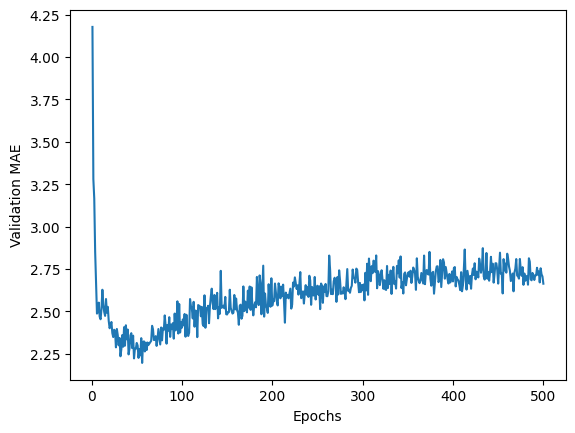

In [28]:
# plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

the plot is visually hard due to scaling issues and relatively high variance:
- omit the first 10 data points
- replace with an exponential moving average of the previous points, to obtain a smooth curve

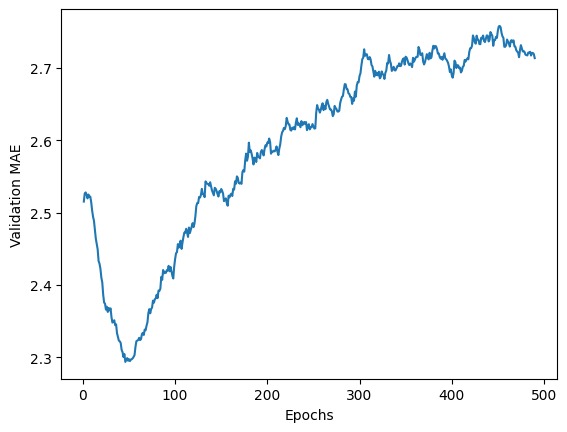

In [30]:
# plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

accroding to the plot, valiation MAE stop improving significantly after 80 epochs, then overfitting

once finishing tuning other parameters of the model (the size of hidden layers, etc), then can train a final production model, with the best parameters

In [32]:
# training the final model

reset_keras()

model = build_model() # get a fresh, compiled model
model.fit(train_data, train_targets, # train on the entirety of data
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2022-11-02 10:31:02.112595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.114862: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.115274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.115550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.115764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

1252


2022-11-02 10:31:02.323666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.323929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.324084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.324295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 10:31:02.324441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

4/4 [==============================] - 0s 4ms/step - loss: 18.1535 - mae: 2.7122


In [33]:
test_mae_score

2.7122342586517334

##### Wrapping up

- regression is done using different loss functions than classification, MAE is a loss function commonly one
- similarly, evaluation metrics to be used for regression differ from those used for classification. naturally, the concept of accuracy doesn't apply for regression, the common regression metric is MAE
- when features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing setp
- when there is little data available, using k-fold validation is a great way to reliably evaluate a model
- when little training data is abailable, it's preferable to use a small network with few hidden layers (typically only one or two), in order to avoid severe overfitting